In [2]:
#importing required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import kurtosis, skew
from sklearn import preprocessing,linear_model,metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statistics
import time
import random

Data Preperation

In [3]:
#Reading data
data=pd.read_csv('OnlineNewsPopularity.csv')
print("shape",data.shape)
print("\n type of the variables \n", data.dtypes)

shape (39644, 61)

 type of the variables 
 url                                object
 timedelta                        float64
 n_tokens_title                   float64
 n_tokens_content                 float64
 n_unique_tokens                  float64
 n_non_stop_words                 float64
 n_non_stop_unique_tokens         float64
 num_hrefs                        float64
 num_self_hrefs                   float64
 num_imgs                         float64
 num_videos                       float64
 average_token_length             float64
 num_keywords                     float64
 data_channel_is_lifestyle        float64
 data_channel_is_entertainment    float64
 data_channel_is_bus              float64
 data_channel_is_socmed           float64
 data_channel_is_tech             float64
 data_channel_is_world            float64
 kw_min_min                       float64
 kw_max_min                       float64
 kw_avg_min                       float64
 kw_min_max                     

In [4]:
#checking for missing values
sum(data.isnull().sum())

0

In [5]:
#remove non-predictive variables
data.drop(['url', ' timedelta'], axis=1, inplace=True)
data.shape

(39644, 59)

In [6]:
#identifying categorical and numerical variables
#Shares variables will be the numerical variable
categorical_var=[' data_channel_is_lifestyle',' data_channel_is_entertainment',' data_channel_is_bus',
             ' data_channel_is_socmed',' data_channel_is_tech',' data_channel_is_world',
             ' weekday_is_monday',' weekday_is_tuesday',' weekday_is_wednesday',' weekday_is_thursday',
             ' weekday_is_friday',' weekday_is_saturday',' weekday_is_sunday',' is_weekend']

data_vars=data.columns.values.tolist()
numerical_var=[i for i in data_vars if i not in categorical_var]
numerical_var=numerical_var[0:len(numerical_var)-1]

In [7]:
#normalizing the numerical variables
data_numerical=data[numerical_var]
scaler = preprocessing.StandardScaler()
scaler.fit(data_numerical)  
data_numerical_scaled = pd.DataFrame(scaler.transform(data_numerical))
data_numerical_scaled.columns=data_numerical.columns

data_catergorical = data[categorical_var]
data_catergorical=data_catergorical.astype(object)

data2 = pd.concat([data_numerical_scaled,data_catergorical,data[' shares']], axis=1)
data2.columns=data.columns

mean :  3395.3801836343455
median: 1400.0
var  :  135182573.71299252
skew :  33.9625997792866
kurt :  1832.4413727401281


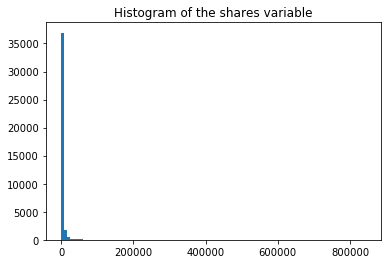

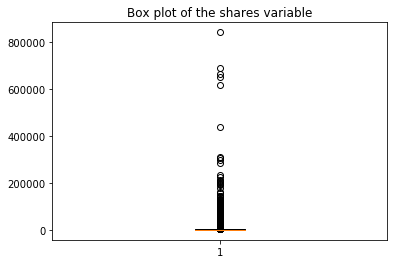

In [8]:
#checking for skewness and kurtosis of the outcome variable (shares)
print("mean : ", np.mean(data[' shares']))
print("median:", np.median(data[' shares']))
print("var  : ", np.var(data[' shares']))
print("skew : ",skew(data[' shares']))
print("kurt : ",kurtosis(data[' shares']))

plt.hist(data[' shares'],bins=100)
plt.title('Histogram of the shares variable')
plt.show()

plt.boxplot(data[' shares'])
plt.title('Box plot of the shares variable')
plt.show()


In [9]:
#dividing data into Predictors(X) and outcome(Y)
Y_li=pd.DataFrame(data2[' shares'])
X_li=data2.drop([' shares'], axis=1)

Defining all required functions

In [10]:
#Linear regression with Normal Equations
def linear_regression(X, Y):
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    return regr

In [11]:
#Linear Regression with Gradient Descent
def li_gradient_descent(X, y, theta, alpha, convergence_threshold):
    
    cost_history=[]
    
    while 1:
        hypothesis = X.dot(theta)
        loss = hypothesis-y
        gradient = X.T.dot(loss)/len(X)
        theta = theta - alpha*gradient
        cost=np.sum((X.dot(theta)-y)**2)/2/len(y)
        #print(cost)
        cost_history.append(cost)
        if len(cost_history)>=2:
            if cost_history[len(cost_history)-2]-cost_history[len(cost_history)-1]>convergence_threshold: 
                continue
            else: 
                break
        else : continue

    return theta, cost_history

In [12]:
#linear regression evaluation metrics
def linear_regression_predict(Y_actual_train, Y_actual_test, Y_pred_train, Y_pred_test):
    print("\n R2 score for train/ test ")
    print('Train: %.4f' % r2_score(Y_actual_train, Y_pred_train))
    print('Test: %.4f' % r2_score(Y_actual_test, Y_pred_test))    
    return None 

In [13]:
#Graph of the cost function
def cost_graph(cost, title):
    plt.plot(cost)
    plt.xlabel('Number of iterations')
    plt.ylabel('Cost')
    plt.title(title)
    plt.show()
    return None

In [14]:
#Logistic regression with Normal Equations
def logistic_regression(X, Y):
    model = LogisticRegression()
    model = model.fit(X,Y.astype('int'))
    return model

In [15]:
#logistic regression evaluation metrics
def logistic_regression_predict(Y_actual_train, Y_actual_test, Y_pred_train, Y_pred_test):
    print("train data")
    print("Accuracy: {} %".format(100 - np.mean(np.abs(Y_actual_train.astype('int') - Y_pred_train)) * 100))
    print("\nconfusion matrix:\n",metrics.confusion_matrix(Y_actual_train.astype('int'), Y_pred_train))
    print("\nclassification report:\n",metrics.classification_report(Y_actual_train.astype('int'), Y_pred_train))

    print("test data")
    print("Accuracy: {} %".format(100 - np.mean(np.abs(Y_actual_test.astype('int') - Y_pred_test)) * 100))
    print("\nconfusion matrix:\n",metrics.confusion_matrix(Y_actual_test.astype('int'), Y_pred_test))
    print("\nclassification report:\n",metrics.classification_report(Y_actual_test.astype('int'), Y_pred_test))
    
    return None

In [17]:
#logistic regression with gradient descent
def lo_optimize(w,b,X, Y,learning_rate, convergence_threshold):
    costs = []
    
    while 1:
        
        m = X.shape[1]
    
        #forward
        z=-1*(np.dot(w.T,X)+b)
        A = 1/(1+2.7182818284590451**z)                                   
        cost = np.sum(Y*np.log(A.astype(float))+(1-Y)*np.log(1-A.astype(float)))/m*-1                                
    
        #backward
        dw = np.dot(X,((A-Y).T))/m
        db = np.sum(A-Y)/m
      
        w = w-learning_rate*dw
        b = b-learning_rate*db
       
        costs.append(cost)
        if len(costs)>=2:
            if costs[len(costs)-2]-costs[len(costs)-1]>convergence_threshold: 
                continue
            else: 
                break
        else : continue
        
    return w, b, costs

In [18]:
#Logistic Regression Predict function

def lo_predict(w, b, X, cutoff):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    z=-1*(np.dot(w.T,X)+b)
    A = 1/(1+2.7182818284590451**z)   
    
    for i in range(A.shape[1]):
        Y_prediction=np.where(A>cutoff,1.,0)
        
    return Y_prediction

In [19]:
#Logistic Regression Predict probability

def lo_predict_prob(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    z=-1*(np.dot(w.T,X)+b)
    A = 1/(1+2.7182818284590451**z)   
    
        
    return A

In [69]:
#The optimal cut off would be where tpr is high and fpr is low
def threshold(Y_actual,Y_probs):
    
    fpr, tpr, threshold = metrics.roc_curve(Y_actual, Y_probs)
    roc_auc = metrics.auc(fpr, tpr)


    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})

    th=roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    
    return np.array(th['thresholds'])[0]

# Question 1. For all Features

Linear regression with Normal Equations for all the features

In [21]:
X_train_li, X_test_li, Y_train_li, Y_test_li = train_test_split(X_li, Y_li, test_size=0.3, random_state=42)

In [22]:
#linear regression with Normal Equations for all the features
regr = linear_regression(X_train_li,Y_train_li)

# Make predictions 
Y_pred_train_li = regr.predict(X_train_li)
Y_pred_test_li = regr.predict(X_test_li)

print("linear regression with Normal Equations for all the features")
print('Coefficients: \n', regr.coef_)

linear_regression_predict(Y_train_li,Y_test_li,Y_pred_train_li,Y_pred_test_li  )

linear regression with Normal Equations for all the features
Coefficients: 
 [[  2.50169075e+02   5.32793762e+02   1.94363478e+04  -9.11480562e+03
   -1.09738630e+04   2.62821726e+02  -2.22221262e+02  -5.26540235e+00
    1.12044728e+01  -6.45504565e+02   7.59195478e+00   7.15347110e+01
    3.39028035e+02  -7.06500801e+01  -4.41579731e+01  -8.78026319e+01
   -3.19463182e+02  -4.54552470e+02  -1.43567113e+03   2.26687297e+03
    5.81155417e+02   5.11118697e+02  -5.38211645e+02  -3.57361252e+04
   -3.01061390e+04  -3.87282815e+04  -4.03399505e+04  -3.95891238e+04
    4.47462971e+02   2.27827576e+02  -4.32618417e+02   1.83675439e+01
    4.24353033e+02   3.93297908e+02  -6.32989747e+01  -1.63334049e+02
   -2.77902994e+01  -9.85478721e+01   5.94259795e+01  -1.72234887e+02
    7.18378347e+01   1.17973053e+02   1.66346815e+02   2.90131307e+01
   -5.41506453e+02  -1.00053178e+03  -8.54559967e+02  -5.62502084e+02
   -3.65221548e+02  -6.29684651e+02   5.69275582e+14   5.69275582e+14
    5.6927558

Linear Regression with Gradient Descent using all the Features

In [23]:
#prepating data for linear regression with gradient descent for all the features
X_li_gd=X_li.copy()
Y_li_gd=Y_li.copy()
#adding a column of 1s as intercept to x  and intializing all the parameters to beta
X_li_gd['intercept']=1
X_li_gd2=np.array(X_li_gd)
Y_li_gd2=np.array(Y_li_gd).flatten()
theta=np.array([0]*X_li_gd.shape[1])
#dividing into test and train
X_train_li_gd, X_test_li_gd, Y_train_li_gd, Y_test_li_gd = train_test_split(X_li_gd2, Y_li_gd2, test_size=0.3, random_state=42)

In [36]:
#hyper paramters
start_time = time.time()
convergence_threshold = 10
alpha = 0.01
theta_final, cost_his = li_gradient_descent(X_train_li_gd,Y_train_li_gd,theta,alpha, convergence_threshold)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1746.8280565738678 seconds ---


In [37]:
len(cost_his)

3091

linear regression with gradient descent for all the features
cost function


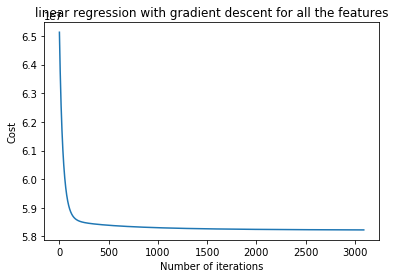

Coefficients: 
 [243.2018299255131 265.8966099399146 45.17820217696311 -28.451556444213065
 8.581983277649348 326.4997677532402 -217.2310212060797 17.857154498433662
 51.474819735593556 -251.578478132051 145.995336723642 164.48910403586217
 188.92309013618433 -23.191855969727445 -108.97695175061449
 -108.16548896159176 -95.16055914545565 -353.3892709557618
 -1143.0784436289466 2004.3511652517852 435.3913774390868 277.3340353000956
 -230.4808159439964 161.1162004243497 14.667607528745375 -323.3869710872427
 246.7762867407465 -93.6004745070665 332.8066497644251 114.86134754319939
 -237.70791027848426 58.916243663186066 -10.441081969594784
 -49.03040790425735 -56.35080367158005 -95.7670431734815 -96.71024594826004
 -84.10798679457568 54.07045239405504 -150.73535801036104 51.86512654513573
 47.732034660768306 121.1966303031335 52.026507773053076 34.50154626897878
 -711.7372959386369 -244.35031061360678 283.31551044747266
 387.7638024166296 345.65208990711164 816.296533961093 267.9692553313

In [39]:
print('linear regression with gradient descent for all the features')

print("cost function")
cost_graph(cost_his,'linear regression with gradient descent for all the features')

print('Coefficients: \n', theta_final)

Y_pred_train_li_gd=X_train_li_gd.dot(theta_final)
Y_pred_test_li_gd=X_test_li_gd.dot(theta_final)

linear_regression_predict(Y_train_li_gd,Y_test_li_gd,Y_pred_train_li_gd,Y_pred_test_li_gd)

Logistic regression with Normal Equations for all the features

In [24]:
#Preparing data for Linear regression with Normal Equations for all the features
data3=pd.concat([data_numerical_scaled,data_catergorical,data[' shares']], axis=1)

#Considering if the number of shares above 1400 as high (denoted by 1) and the rest as low (denoted by 0)
#since the shares is skewed, considering a mid point (median) instead of mean
data3[' shares2']=np.where(data3[' shares']>1400, 1, 0)
Y_lo=data3[' shares2']
Y_lo=Y_lo.astype(object)
X_lo=data3.drop([' shares2',' shares'], axis=1)
print("split of number of records classified as high shares (1) vs low shares(0)\n",Y_lo.value_counts())

split of number of records classified as high shares (1) vs low shares(0)
 0    20082
1    19562
Name:  shares2, dtype: int64


Box plot of shares inforamtion for data classified as low shares


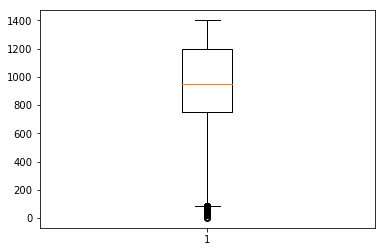

Box plot of shares inforamtion for data classified as high shares


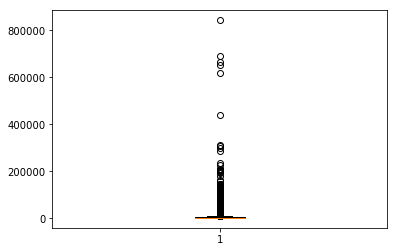

In [25]:
data_0=data3[data3[' shares2']==0]
data_1=data3[data3[' shares2']==1]
print("Box plot of shares inforamtion for data classified as low shares")
plt.boxplot(data_0[' shares'])
plt.show()
print("Box plot of shares inforamtion for data classified as high shares")
plt.boxplot(data_1[' shares'].values)
plt.show()

In [26]:
#split of the data
X_train_lo, X_test_lo, Y_train_lo, Y_test_lo = train_test_split(X_lo, Y_lo, test_size=0.3, random_state=42)

In [70]:
model=logistic_regression(X_train_lo,Y_train_lo)
print(model)
Y_probs_trian_lo = model.predict_proba(X_train_lo)
Y_probs_test_lo = model.predict_proba(X_test_lo)

th_lo=threshold(Y_train_lo, Y_probs_trian_lo[:,1])

print("\n threshold for train",th_lo)
print("\n")

logistic_regression_predict(Y_train_lo, Y_test_lo,
                            np.where(Y_probs_trian_lo[:,1]>th_lo,1,0), 
                            np.where(Y_probs_test_lo[:,1]>th_lo,1,0))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

 threshold for train 0.489632927942


train data
Accuracy: 65.43063063063063 %

confusion matrix:
 [[9170 4844]
 [4749 8987]]

classification report:
              precision    recall  f1-score   support

          0       0.66      0.65      0.66     14014
          1       0.65      0.65      0.65     13736

avg / total       0.65      0.65      0.65     27750

test data
Accuracy: 64.64604002017825 %

confusion matrix:
 [[3969 2099]
 [2106 3720]]

classification report:
              precision    recall  f1-score   support

          0       0.65      0.65      0.65      6068
          1       0.64      0.64      0.64      5826

avg / total       0.65      0.65      0.65     11894



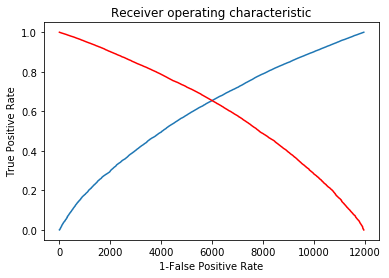

In [80]:
#roc curve to determine the probability
fpr, tpr, threshold = metrics.roc_curve(Y_train_lo, Y_probs_trian_lo[:,1])
roc_auc = metrics.auc(fpr, tpr)

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


Logistic regression with Gradient Descent for all the features

In [28]:
#preparing data
X_train_lo_gd=np.array(X_train_lo.T)
Y_train_lo_gd=np.array(Y_train_lo.T)
X_test_lo_gd=np.array(X_test_lo.T)
Y_test_lo_gd=np.array(Y_test_lo.T)

In [31]:
#hyper paramters of logistic regression
w = np.zeros((X_train_lo_gd.shape[0],1))
b = 0
covergence_threshold=0.000001
learning_rate=0.01
w, b, costs_lo=lo_optimize(w,b,X_train_lo_gd, Y_train_lo_gd, learning_rate, covergence_threshold )

In [ ]:
#prediction    
Y_probs_train_lo_gd=lo_predict_prob(w, b, X_train_lo_gd)
Y_probs_test_lo_gd=lo_predict_prob(w, b, X_test_lo_gd)    

logistic regression with gradient descent for all the features
cost function


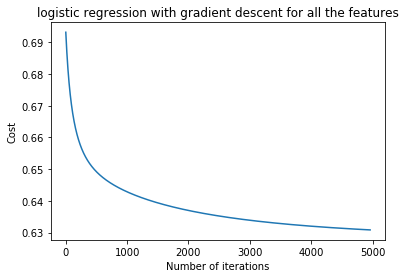


 threshold for train 0.4936280352116201


train data
Accuracy: 65.18558558558559 %

confusion matrix:
 [[9135 4879]
 [4782 8954]]

classification report:
              precision    recall  f1-score   support

          0       0.66      0.65      0.65     14014
          1       0.65      0.65      0.65     13736

avg / total       0.65      0.65      0.65     27750

test data
Accuracy: 64.04910038674961 %

confusion matrix:
 [[3930 2138]
 [2138 3688]]

classification report:
              precision    recall  f1-score   support

          0       0.65      0.65      0.65      6068
          1       0.63      0.63      0.63      5826

avg / total       0.64      0.64      0.64     11894



In [34]:
print('logistic regression with gradient descent for all the features')

print("cost function")
cost_graph(costs_lo,'logistic regression with gradient descent for all the features')

th_lo_gd=threshold(Y_train_lo_gd, Y_probs_train_lo_gd.flatten())
print("\n threshold for train",th_lo_gd)

print("\n")
logistic_regression_predict(Y_train_lo_gd,
                            Y_test_lo_gd,
                            np.where(Y_probs_train_lo_gd.flatten()>th_lo_gd,1,0),
                            np.where(Y_probs_test_lo_gd.flatten()>th_lo_gd,1,0))


# Question 2: Ten Random Ten Features 

Linear Regression with Normal Equations for ten random features

In [52]:
#Generate ten random numbers list
random.seed(8)
list=random.sample(range(58), 10)
list

[14, 23, 24, 8, 12, 45, 2, 5, 54, 15]

In [53]:
X_train_li.iloc[:,list].columns

Index([' data_channel_is_socmed', ' kw_min_avg', ' kw_max_avg', ' num_videos',
       ' data_channel_is_entertainment', ' global_rate_negative_words',
       ' n_unique_tokens', ' num_hrefs', ' title_subjectivity',
       ' data_channel_is_tech'],
      dtype='object')

In [54]:
X_train_li_tenran=X_train_li.iloc[:,list]
X_test_li_tenran=X_test_li.iloc[:,list]
Y_train_li_tenran=Y_train_li
Y_test_li_tenran=Y_test_li

In [55]:
#linear regression with Normal Equations 
regr_tenran = linear_regression(X_train_li_tenran,Y_train_li_tenran)

# Make predictions 
Y_pred_train_li_tenran = regr_tenran.predict(X_train_li_tenran)
Y_pred_test_li_tenran = regr_tenran.predict(X_test_li_tenran)

print('Coefficients: \n', regr_tenran.coef_)

linear_regression_predict(Y_train_li_tenran,Y_test_li_tenran,Y_pred_train_li_tenran,Y_pred_test_li_tenran)

Coefficients: 
 [[  54.87257624  -32.29022903   38.19354265  249.20118903  374.54796727
  -613.59021891   13.31566846  504.31494152  -16.22426426   29.04161384]]

 R2 score for train/ test 
Train: 0.0043
Test: 0.0027


Linear Regression with Gradient Descent using ten random Features

In [56]:
list.append(X_train_li_gd.shape[1]-1)
list

[14, 23, 24, 8, 12, 45, 2, 5, 54, 15, 58]

In [57]:
X_train_li_tenran_gd=X_train_li_gd[:,list]
X_test_li_tenran_gd=X_test_li_gd[:,list]
Y_train_li_tenran_gd=Y_train_li_gd
Y_test_li_tenran_gd=Y_test_li_gd
theta_gd=np.array([0]*X_test_li_tenran_gd.shape[1])

In [59]:
#hyper paramters
start_time = time.time()
convergence_threshold = 1
alpha = 0.1
theta_final_gd, cost_his_gd = li_gradient_descent(X_train_li_tenran_gd,Y_train_li_tenran_gd,theta_gd,alpha, convergence_threshold)
print("--- %s seconds ---" % (time.time() - start_time))

--- 34.99945116043091 seconds ---


In [60]:
len(cost_his_gd)

427

linear regression with gradient descent 
cost function


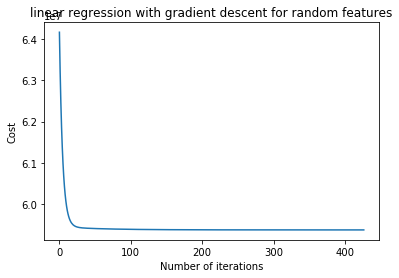

Coefficients: 
 [54.81207758617968 -30.946425296639255 29.485935181615197
 247.34050663182637 374.69969268282904 -577.6587414096218
 13.148081030927772 504.14127333958237 -11.174932973850266
 28.536273201552067 3477.3639365174477]

 R2 score for train/ test 
Train: 0.0043
Test: 0.0027


In [62]:
print('linear regression with gradient descent ')

print("cost function")
cost_graph(cost_his_gd,'linear regression with gradient descent for random features')

print('Coefficients: \n', theta_final_gd)

Y_pred_train_li_tenran_gd=X_train_li_tenran_gd.dot(theta_final_gd)
Y_pred_test_li_tenran_gd=X_test_li_tenran_gd.dot(theta_final_gd)

linear_regression_predict(Y_train_li_tenran_gd,Y_test_li_tenran_gd,Y_pred_train_li_tenran_gd,Y_pred_test_li_tenran_gd)

Logistic regression with Normal Equations for ten random features

In [36]:
X_train_lo_tenran=X_train_li_tenran.copy()
X_test_lo_tenran=X_test_li_tenran.copy()
Y_train_lo_tenran=Y_train_lo.copy()
Y_test_lo_tenran=Y_test_lo.copy()

In [37]:
model=logistic_regression(X_train_lo_tenran,Y_train_lo_tenran)

Y_probs_trian_lo_tenran = model.predict_proba(X_train_lo_tenran)
Y_probs_test_lo_tenran = model.predict_proba(X_test_lo_tenran)

th_lo_tenran=threshold(Y_train_lo_tenran, Y_probs_trian_lo_tenran[:,1])

print("\n threshold for train",th_lo_tenran)
print("\n")

logistic_regression_predict(Y_train_lo_tenran, Y_test_lo_tenran,
                            np.where(Y_probs_trian_lo_tenran[:,1]>th_lo_tenran,1,0), 
                            np.where(Y_probs_test_lo_tenran[:,1]>th_lo_tenran,1,0))


 threshold for train 0.498186837737


train data
Accuracy: 56.129729729729725 %

confusion matrix:
 [[7867 6147]
 [6027 7709]]

classification report:
              precision    recall  f1-score   support

          0       0.57      0.56      0.56     14014
          1       0.56      0.56      0.56     13736

avg / total       0.56      0.56      0.56     27750

test data
Accuracy: 55.91054313099041 %

confusion matrix:
 [[3377 2691]
 [2553 3273]]

classification report:
              precision    recall  f1-score   support

          0       0.57      0.56      0.56      6068
          1       0.55      0.56      0.56      5826

avg / total       0.56      0.56      0.56     11894



Logistic regression with Gradient Descent for ten random features

In [38]:
#preparing data
X_train_lo_tenran_gd=np.array(X_train_lo_tenran.T)
Y_train_lo_tenran_gd=np.array(Y_train_lo_tenran.T)
X_test_lo_tenran_gd=np.array(X_test_lo_tenran.T)
Y_test_lo_tenran_gd=np.array(Y_test_lo_tenran.T)

In [278]:
#hyper paramters of logistic regression
w = np.zeros((X_train_lo_tenran_gd.shape[0],1))
b = 0
covergence_threshold=0.00000001
learning_rate=0.01
w, b, costs_lo_tenran=lo_optimize(w,b,X_train_lo_tenran_gd, Y_train_lo_tenran_gd, learning_rate, covergence_threshold )

In [279]:
len(costs_lo_tenran)

11704

In [280]:
Y_probs_train_lo_tenran_gd=lo_predict_prob(w, b, X_train_lo_tenran_gd)
Y_probs_test_lo_tenran_gd=lo_predict_prob(w, b, X_test_lo_tenran_gd)    

In [ ]:
print("cost function")
cost_graph(costs_lo_tenran,'logistic regression with gradient descent for selected features')

th_lo_tenran_gd=threshold(Y_train_lo_tenran_gd, Y_probs_train_lo_tenran_gd.flatten())
print("\n threshold for train",th_lo_tenran_gd)

print("\n")
logistic_regression_predict(Y_train_lo_tenran_gd,
                            Y_test_lo_tenran_gd,
                            np.where(Y_probs_train_lo_tenran_gd.flatten()>th_lo_tenran_gd,1,0),
                            np.where(Y_probs_test_lo_tenran_gd.flatten()>th_lo_tenran_gd,1,0))



# Question 3: Ten Selected Features¶

In [50]:
#variable selection and data preparation
X_train_li_tensel=X_train_li.loc[: , [' n_unique_tokens',' n_non_stop_unique_tokens',
              ' self_reference_max_shares', ' is_weekend', ' min_positive_polarity', 
              ' title_sentiment_polarity',' average_token_length', 
              ' max_negative_polarity', ' num_imgs',' data_channel_is_bus']]
X_test_li_tensel=X_test_li.loc[: , [' n_unique_tokens',' n_non_stop_unique_tokens',
              ' self_reference_max_shares', ' is_weekend', ' min_positive_polarity', 
              ' title_sentiment_polarity',' average_token_length', 
              ' max_negative_polarity', ' num_imgs',' data_channel_is_bus']]
Y_train_li_tensel=Y_train_li
Y_test_li_tensel=Y_test_li

Linear Regression with Normal Equations for ten selected features

In [51]:

regr_tensel = linear_regression(X_train_li_tensel,Y_train_li_tensel)

# Make predictions 
Y_pred_train_li_tensel = regr_tensel.predict(X_train_li_tensel)
Y_pred_test_li_tensel = regr_tensel.predict(X_test_li_tensel)

print('Coefficients: \n', regr_tensel.coef_)

linear_regression_predict(Y_train_li_tensel,Y_test_li_tensel,Y_pred_train_li_tensel,Y_pred_test_li_tensel)

Coefficients: 
 [[ 21351.69914882 -21348.54542169   -209.46786886    201.27091144
   -1233.88810286    759.76480047   -191.49924079   -190.45166014
     205.34838624    371.26914513]]

 R2 score for train/ test 
Train: 0.0072
Test: 0.0045


Linear Regression with Gradient Descent using ten selected Features

In [210]:
X_li_gd_tensel=np.array(X_li_gd.loc[: , [' n_unique_tokens',' n_non_stop_unique_tokens',
              ' self_reference_max_shares', ' is_weekend', ' min_positive_polarity', 
              ' title_sentiment_polarity',' average_token_length', 
              ' max_negative_polarity', ' num_imgs',' data_channel_is_bus','intercept']])
Y_li_gd_tensel=np.array(Y_li_gd).flatten()
#dividing into test and train
X_train_li_tensel_gd, X_test_li_tensel_gd, Y_train_li_tensel_gd, Y_test_li_tensel_gd = train_test_split(X_li_gd_tensel, Y_li_gd_tensel, test_size=0.3, random_state=42)
theta_gd_sel=np.array([0]*X_train_li_tensel_gd.shape[1])

In [ ]:
#hyper paramters
start_time = time.time()
convergence_threshold = 0.1
alpha = 0.1
theta_final_gd, cost_his_gd_sel = li_gradient_descent(X_train_li_tensel_gd,Y_train_li_tensel_gd,theta_gd_sel,alpha, convergence_threshold)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print('linear regression with gradient descent for selected features')

print("cost function")
cost_graph(cost_his_gd_sel,'linear regression with gradient descent for selected features')

print('Coefficients: \n', theta_final_gd)

Y_pred_train_li_tensel_gd=X_train_li_tensel_gd.dot(theta_final_gd)
Y_pred_test_li_tensel_gd=X_test_li_tensel_gd.dot(theta_final_gd)

linear_regression_predict(Y_train_li_tensel_gd,Y_test_li_tensel_gd,Y_pred_train_li_tensel_gd,Y_pred_test_li_tensel_gd)

Logistic regression with Normal Equations for ten selected features

In [40]:
X_train_lo_tensel=X_train_li_tensel.copy()
X_test_lo_tensel=X_test_li_tensel.copy()
Y_train_lo_tensel=Y_train_lo.copy()
Y_test_lo_tensel=Y_test_lo.copy()

In [225]:
model=logistic_regression(X_train_lo_tensel,Y_train_lo_tensel)

Y_probs_trian_lo_tensel = model.predict_proba(X_train_lo_tensel)
Y_probs_test_lo_tensel = model.predict_proba(X_test_lo_tensel)

th_lo_tensel=threshold(Y_train_lo_tensel, Y_probs_trian_lo_tensel[:,1])

print("\n threshold for train",th_lo_tensel)
print("\n")

logistic_regression_predict(Y_train_lo_tensel, Y_test_lo_tensel,
                            np.where(Y_probs_trian_lo_tensel[:,1]>th_lo_tensel,1,0), 
                            np.where(Y_probs_test_lo_tensel[:,1]>th_lo_tensel,1,0))


 threshold for train 0.497374257151


train data
Accuracy: 58.072072072072075 %

confusion matrix:
 [[8139 5875]
 [5760 7976]]

classification report:
              precision    recall  f1-score   support

          0       0.59      0.58      0.58     14014
          1       0.58      0.58      0.58     13736

avg / total       0.58      0.58      0.58     27750

test data
Accuracy: 57.65932402892214 %

confusion matrix:
 [[3509 2559]
 [2477 3349]]

classification report:
              precision    recall  f1-score   support

          0       0.59      0.58      0.58      6068
          1       0.57      0.57      0.57      5826

avg / total       0.58      0.58      0.58     11894



Logistic regression with Gradient Descent for selected features

In [129]:
#preparing data
X_train_lo_tensel_gd=np.array(X_train_lo_tensel.T)
Y_train_lo_tensel_gd=np.array(Y_train_lo_tensel.T)
X_test_lo_tensel_gd=np.array(X_test_lo_tensel.T)
Y_test_lo_tensel_gd=np.array(Y_test_lo_tensel.T)

In [226]:
#hyper paramters of logistic regression
w = np.zeros((X_train_lo_tensel_gd.shape[0],1))
b = 0
covergence_threshold=0.000000001
learning_rate=0.01
w, b, costs_lo_tensel=lo_optimize(w,b,X_train_lo_tensel_gd, Y_train_lo_tensel_gd, learning_rate, covergence_threshold)

In [227]:
len(costs_lo_tensel)

29785

In [229]:
Y_probs_train_lo_tensel_gd=lo_predict_prob(w, b, X_train_lo_tensel_gd)
Y_probs_test_lo_tensel_gd=lo_predict_prob(w, b, X_test_lo_tensel_gd)    

logistic regression with gradient descent for selected features
cost function


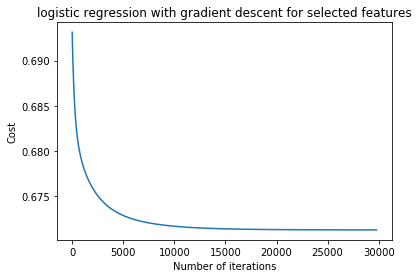


 threshold for train 0.4979197694907886


train data
Accuracy: 58.01801801801802 %

confusion matrix:
 [[8131 5883]
 [5767 7969]]

classification report:
              precision    recall  f1-score   support

          0       0.59      0.58      0.58     14014
          1       0.58      0.58      0.58     13736

avg / total       0.58      0.58      0.58     27750

test data
Accuracy: 57.701362031276275 %

confusion matrix:
 [[3537 2531]
 [2500 3326]]

classification report:
              precision    recall  f1-score   support

          0       0.59      0.58      0.58      6068
          1       0.57      0.57      0.57      5826

avg / total       0.58      0.58      0.58     11894



In [230]:
print('logistic regression with gradient descent for selected features')

print("cost function")
cost_graph(costs_lo_tensel,'logistic regression with gradient descent for selected features')

th_lo_tensel_gd=threshold(Y_train_lo_tensel_gd, Y_probs_train_lo_tensel_gd.flatten())
print("\n threshold for train",th_lo_tensel_gd)

print("\n")
logistic_regression_predict(Y_train_lo_tensel_gd,
                            Y_test_lo_tensel_gd,
                            np.where(Y_probs_train_lo_tensel_gd.flatten()>th_lo_tensel_gd,1,0),
                            np.where(Y_probs_test_lo_tensel_gd.flatten()>th_lo_tensel_gd,1,0))

